#thesis method-1

# Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data


## Approach 1: Convolutional Neural Network on Raw Sensor Data

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

## Reading Measurement Data and Preprocessing

In [ ]:
use_reference_models = True

In [ ]:
import os

In [ ]:
pwd

'C:\\Users\\IITJMU'

In [ ]:
model_path = 'reference'

In [ ]:
import pandas as pd
data0D = pd.read_csv("0D.csv")
data0D

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
0,0.0,28.610235,0.000000,0.000000,0.000000
1,0.0,28.610235,0.000000,0.000000,0.000000
2,0.0,28.610235,0.000000,0.000000,0.000000
3,0.0,28.610235,0.000000,0.000000,0.000000
4,0.0,28.610235,0.000000,0.000000,0.000000
...,...,...,...,...,...
26423290,2.0,643.383380,0.001339,0.000769,0.003015
26423291,2.0,643.383380,0.001261,0.000952,0.003138
26423292,2.0,643.383380,0.000966,0.000895,0.003057
26423293,2.0,643.383380,0.000976,0.000744,0.002798


In [ ]:
data0E = pd.read_csv('0E.csv')
data1D = pd.read_csv('1D.csv')
data1E = pd.read_csv('1E.csv')
data2D = pd.read_csv('2D.csv')
data2E = pd.read_csv('2E.csv')
data3D = pd.read_csv('3D.csv')
data3E = pd.read_csv('3E.csv')
data4D = pd.read_csv('4D.csv')
data4E = pd.read_csv('4E.csv')

In [ ]:
data4E

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
0,0.0,28.610235,0.000000,0.000000,0.000000
1,0.0,28.610235,0.000000,0.000000,0.000000
2,0.0,28.610235,0.000000,0.000000,0.000000
3,0.0,28.610235,0.000000,0.000000,0.000000
4,0.0,28.610235,0.000000,0.000000,0.000000
...,...,...,...,...,...
6914042,4.0,1080.458200,0.002939,-0.003955,0.002704
6914043,4.0,1080.458200,-0.000345,0.002913,0.000757
6914044,4.0,1080.458200,-0.003408,0.002537,-0.001725
6914045,4.0,1080.458200,-0.004315,-0.002156,-0.000253


In [ ]:
skip = 50000
data0D = data0D.iloc[skip:,:]
data1D = data1D.iloc[skip:,:]
data2D = data2D.iloc[skip:,:]
data3D = data3D.iloc[skip:,:]
data4D = data4D.iloc[skip:,:]
data0E = data0E.iloc[skip:,:]
data1E = data1E.iloc[skip:,:]
data2E = data2E.iloc[skip:,:]
data3E = data3E.iloc[skip:,:]
data4E = data4E.iloc[skip:,:]

At the moment only the first vibration sensor **Vibration_1** is used for the analysis. All four data streams may need to be included in the future.

In [ ]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_1'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Now the dataset for training X contains 32142 samples with 4096 values each as well as the associated label information y with 32142 labels (one label per sample). The dataset for validating the trained model X_val contains 8420 samples plus the labels y_val accordingly.

In [ ]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32166, 4096) (32166,) (8359, 4096) (8359,)


## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28949, 4096, 1) (28949,) (3217, 4096, 1) (3217,)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

weight_for_0 = len(y)/(2*len(y[y==0]))
weight_for_1 = len(y)/(2*len(y[y==1]))
class_weight = {0: weight_for_0, 1: weight_for_1}

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 128
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 100 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*10,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'sigmoid')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='min')

    classifier.compile(optimizer = Adam(lr=learning_rate), loss = 'binary_crossentropy',
                       metrics = ['accuracy'])

    classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint],
                   class_weight=class_weight)
    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

In [ ]:
if not use_reference_models:
    for i in range(1,5):
        train_models(i)

#### Evaluation

In [ ]:
X_val_1 = X_val[:len(y0_val),:,:]
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y1_val),:,:]
X_val_3 = X_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val),:,:]
X_val_4 = X_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val),:,:]
X_val_5 = X_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:,:]

In [ ]:
accuracies = []
accuracies_all = []
for layer_n in range(1,5):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)

    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
    val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

262/262 [==============================] - 4s 13ms/step - loss: 0.2237 - accuracy: 0.9763


In [ ]:
accuracies_all

array([0.93551862, 0.90872115, 0.98061967, 0.97631294])

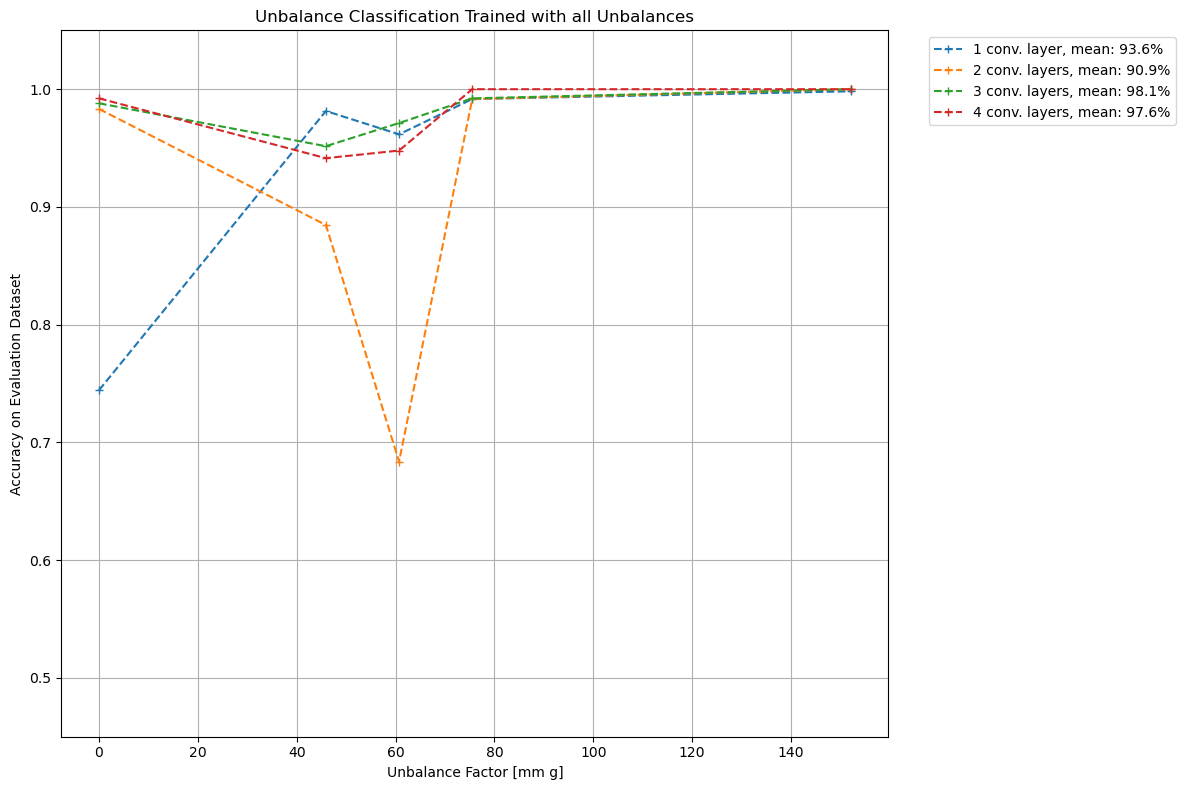

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:], label=f"1 conv. layer, mean: {100.0*accuracies_all[0]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[1,:], label=f"2 conv. layers, mean: {100.0*accuracies_all[1]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[2,:], label=f"3 conv. layers, mean: {100.0*accuracies_all[2]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[3,:], label=f"4 conv. layers, mean: {100.0*accuracies_all[3]:.1f}%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0.45, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()

## Rotation Speed Dependent Evaluation

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model(f"{model_path}/cnn_1_layers.h5")
model2 = load_model(f"{model_path}/cnn_2_layers.h5")
model3 = load_model(f"{model_path}/cnn_3_layers.h5")
model4 = load_model(f"{model_path}/cnn_4_layers.h5")

In [ ]:
def v2rpm(v):
    return 212*v + 209

from scipy.stats import mode
# 3s ramp up
fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
# complete voltage sweep
measurement_cycle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# measurement: start-up + 2 voltage sweeps
measurement = np.concatenate([fade_in, np.tile(measurement_cycle,3)])
# select the data as actually used
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_val_1)],
                                voltages_measurement[:len(X_val_2)],
                                voltages_measurement[:len(X_val_3)],
                                voltages_measurement[:len(X_val_4)],
                                voltages_measurement[:len(X_val_5)]])
rpms_used = v2rpm(voltages_used)

C:\Users\IITJMU\AppData\Local\Temp\ipykernel_7636\1398942425.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  voltages_measurement = mode(measurement1, axis=1)[0]


In [ ]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range1 = []
errors_per_rpm_range2 = []
errors_per_rpm_range3 = []
errors_per_rpm_range4 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range1.append(
        1-np.mean(np.abs(np.int32(model1.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range2.append(
        1-np.mean(np.abs(np.int32(model2.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range3.append(
        1-np.mean(np.abs(np.int32(model3.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range4.append(
        1-np.mean(np.abs(np.int32(model4.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))

7/7 [==============================] - 0s 11ms/step


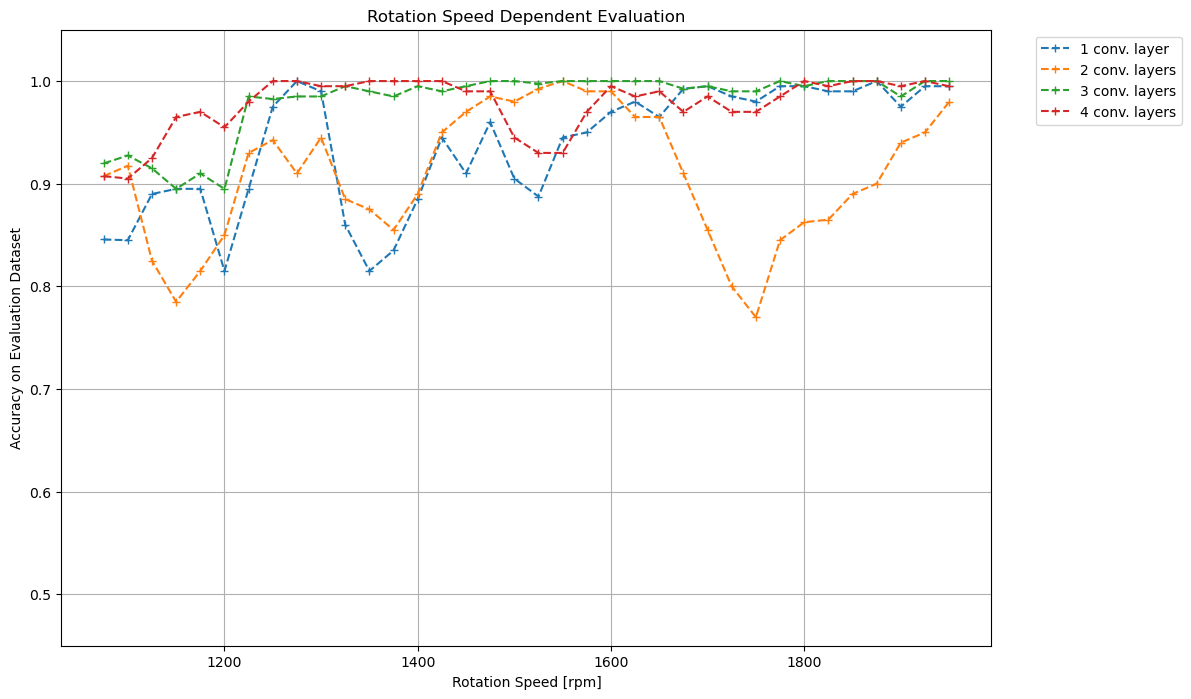

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Rotation Speed Dependent Evaluation")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, marker="+", ls="--", label="1 conv. layer")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, marker="+", ls="--", label="2 conv. layers")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, marker="+", ls="--", label="3 conv. layers")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, marker="+", ls="--", label="4 conv. layers")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Rotation Speed [rpm]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0.45, 1.05])
plt.grid(True)
plt.show()

## Pairwise Unbalance Training and Evaluation

In [ ]:
X_dev = [X0, X1, X2, X3, X4]
y_dev = [y0, y1, y2, y3, y4]

X_val_separated = [X_val_1, X_val_2, X_val_3, X_val_4, X_val_5]
y_val_separated = [y0_val, y1_val, y2_val, y3_val, y4_val]

In [ ]:
for n_conv_layers in range(1,5):
    for dataset_i in range(4):
        X_dev_i = np.concatenate([X_dev[0], X_dev[dataset_i+1]])
        y_dev_i = np.concatenate([y_dev[0], y_dev[dataset_i+1]])
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])

        train_test_ratio = 0.9
        X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
            X_dev_i,y_dev_i, test_size = 1-train_test_ratio, random_state = 0)
        X_train_i = np.reshape(X_train_i, (X_train_i.shape[0], X_train_i.shape[1], 1))
        X_test_i = np.reshape(X_test_i, (X_test_i.shape[0], X_test_i.shape[1], 1))


        if not use_reference_models:
            weight_for_0 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==0]))
            weight_for_1 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==1]))
            class_weight = {0: weight_for_0, 1: weight_for_1}

            n_dense_units = 128
            dropout_rate = 0.0
            use_batch_normalization = True # [True, False]
            filter_size = 9 # [5,7,9]
            learning_rate = 0.0001
            n_epochs = 100 # [50,100,200]

            X_in = Input(shape=(X_train.shape[1],1))
            x = X_in
            for j in range(n_conv_layers):
                print(j)
                x = Conv1D(filters=(j+1)*10,
                           kernel_size=filter_size,
                           strides=1,
                           activation='linear',
                           kernel_initializer='he_uniform')(x)
                if use_batch_normalization:
                    x = BatchNormalization()(x)
                x = LeakyReLU(alpha=0.05)(x)
                x = MaxPooling1D(pool_size=5, strides=2)(x)
            x = Flatten()(x)
            x = Dense(units = n_dense_units, activation='linear')(x)
            x = ReLU()(x)
            x = Dropout(rate=dropout_rate)(x)
            X_out = Dense(units = 1, activation = 'sigmoid')(x)
            classifier = Model(X_in, X_out)

            best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers_dataset_pair_{dataset_i}.h5"
            checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                         verbose=1, save_best_only=True, mode='min')
            classifier.compile(optimizer = Adam(lr=learning_rate), loss = 'binary_crossentropy',
                               metrics = ['accuracy'])
            classifier.summary()

            classifier.fit(X_train_i, y_train_i, epochs = n_epochs, batch_size = 128,
                       validation_data=(X_test_i, y_test_i), callbacks=[checkpoint],
                           class_weight=class_weight)

        best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers_dataset_pair_{dataset_i}.h5"
        classifier = load_model(best_model_filepath)
        train_acc = classifier.evaluate(X_train_i, y_train_i)
        val_acc = classifier.evaluate(X_val_i, y_val_i)
        print(f"Layers: {layer_n}, dataset pair {dataset_i}")
        print(train_acc)
        print(val_acc)

105/105 [==============================] - 1s 5ms/step - loss: 1.3558 - accuracy: 0.8118
Layers: 4, dataset pair 0
[0.07540404796600342, 0.9675414562225342]
[1.3558255434036255, 0.8118456602096558]
105/105 [==============================] - 1s 5ms/step - loss: 0.9981 - accuracy: 0.6370
Layers: 4, dataset pair 1
[0.15350987017154694, 0.9344785809516907]
[0.998137891292572, 0.6370170712471008]
105/105 [==============================] - 1s 5ms/step - loss: 0.8464 - accuracy: 0.6777
Layers: 4, dataset pair 2
[0.17882083356380463, 0.9203004837036133]
[0.8464228510856628, 0.6777378916740417]
105/105 [==============================] - 1s 5ms/step - loss: 0.0255 - accuracy: 0.9949
Layers: 4, dataset pair 3
[0.06612363457679749, 0.9858388900756836]
[0.025488944724202156, 0.9949178099632263]
105/105 [==============================] - 1s 7ms/step - loss: 2.8528 - accuracy: 0.7496
Layers: 4, dataset pair 0
[0.032745297998189926, 0.9952520728111267]
[2.8528213500976562, 0.749626100063324]
105/105 [

In [ ]:
accuracies_single = []
for layer_n in range(1,5):
    accuracies_layer_i = []
    for dataset_i in range(4):
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])
        filepath = f"{model_path}/cnn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        model_i = load_model(filepath)
        accuracies_layer_i.append(model_i.evaluate(X_val_i, y_val_i)[1])
    accuracies_single.append(accuracies_layer_i)
accuracies_single = np.array(accuracies_single)

105/105 [==============================] - 2s 12ms/step - loss: 0.0059 - accuracy: 0.9982


In [ ]:
np.mean(accuracies_single, axis=1)

array([0.78037961, 0.79249549, 0.78014812, 0.77707924])

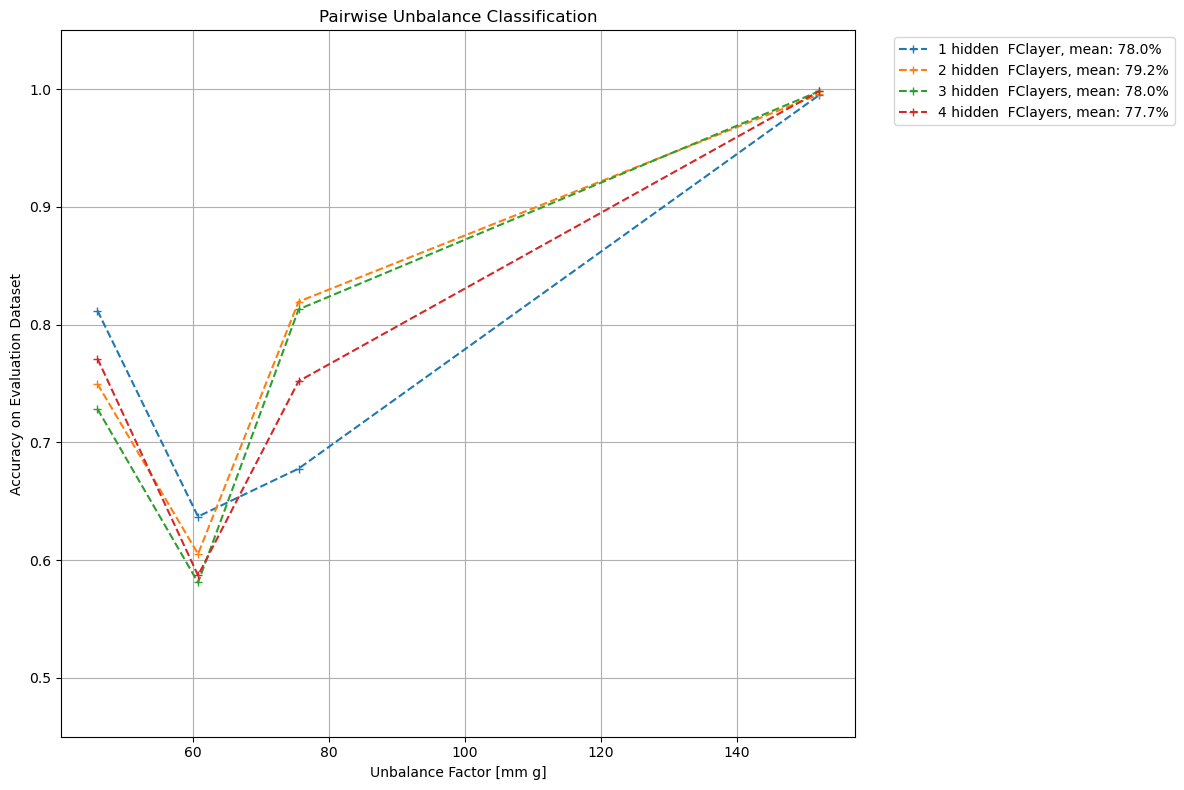

In [ ]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Pairwise Unbalance Classification")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances[1:], accuracies_single[0,:],
         label=f"1 hidden  FClayer, mean: {100.0*np.mean(accuracies_single[0,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[1,:],
         label=f"2 hidden  FClayers, mean: {100.0*np.mean(accuracies_single[1,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[2,:],
         label=f"3 hidden  FClayers, mean: {100.0*np.mean(accuracies_single[2,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[3,:],
         label=f"4 hidden  FClayers, mean: {100.0*np.mean(accuracies_single[3,:]):.1f}%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0.45, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()

## Plotting all Experiments

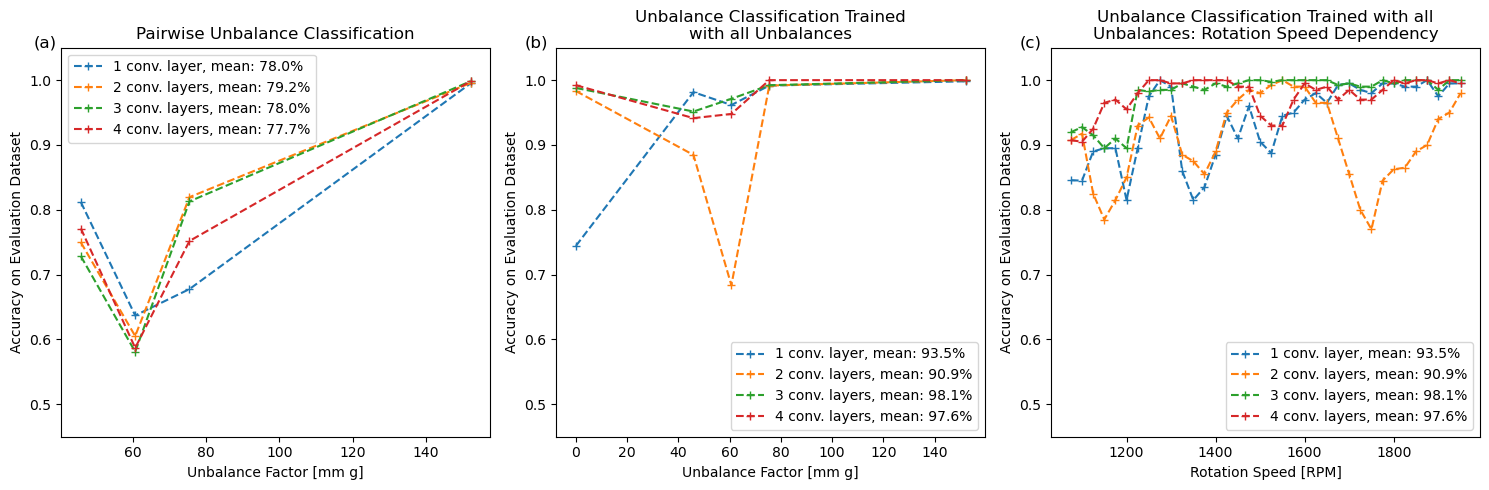

In [ ]:
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot(132, title = "Unbalance Classification Trained\nwith all Unbalances")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:],
         label=f"1 conv. layer, mean: {100.0*np.mean(accuracies[0,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[1,:],
         label=f"2 conv. layers, mean: {100.0*np.mean(accuracies[1,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[2,:],
         label=f"3 conv. layers, mean: {100.0*np.mean(accuracies[2,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[3,:],
         label=f"4 conv. layers, mean: {100.0*np.mean(accuracies[3,:]):.1f}%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.ylim([0.45, 1.05])
plt.legend(loc="lower right")
ax1.text(-20, 1.05,"(b)", fontsize=12)
ax2=plt.subplot(131, title = "Pairwise Unbalance Classification")
ax2.plot(1e6*unbalances[1:], accuracies_single[0,:],
         label=f"1 conv. layer, mean: {100.0*np.mean(accuracies_single[0,:]):.1f}%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies_single[1,:],
         label=f"2 conv. layers, mean: {100.0*np.mean(accuracies_single[1,:]):.1f}%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies_single[2,:],
         label=f"3 conv. layers, mean: {100.0*np.mean(accuracies_single[2,:]):.1f}%", marker="+", ls="--")
ax2.plot(1e6*unbalances[1:], accuracies_single[3,:],
         label=f"4 conv. layers, mean: {100.0*np.mean(accuracies_single[3,:]):.1f}%", marker="+", ls="--")
plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.ylim([0.45, 1.05])
plt.legend()
ax2.text(33, 1.05,"(a)", fontsize=12)
ax3 = plt.subplot(133, title="Unbalance Classification Trained with all\nUnbalances: Rotation Speed Dependency")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1,
         label=f"1 conv. layer, mean: {100.0*np.mean(accuracies[0,:]):.1f}%", marker="+", ls="--")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2,
         label=f"2 conv. layers, mean: {100.0*np.mean(accuracies[1,:]):.1f}%", marker="+", ls="--")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3,
         label=f"3 conv. layers, mean: {100.0*np.mean(accuracies[2,:]):.1f}%", marker="+", ls="--")
ax3.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4,
         label=f"4 conv. layers, mean: {100.0*np.mean(accuracies[3,:]):.1f}%", marker="+", ls="--")

plt.ylabel("Accuracy on Evaluation Dataset")
plt.xlabel("Rotation Speed [RPM]")
plt.ylim([0.45, 1.05])
plt.legend(loc="lower right")
ax3.text(960, 1.05,"(c)", fontsize=12)
plt.tight_layout()
plt.show()